In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=d0ce3d4f180cc427067ffc30185a270022549c2b1377f02dd0f3e5a57aea5c13
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [4]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, attr_file, transform=None):
        self.root_dir = root_dir
        self.attr_file = attr_file
        self.transform = transform

        # Read attribute file
        self.attrs = pd.read_csv(attr_file, delim_whitespace=True, skiprows=1)
        self.attrs = self.attrs.iloc[:, :40]  # Select the first 40 attributes
        self.attrs.replace(to_replace=-1, value=0, inplace=True)  # Replace -1 with 0
        self.images = self.attrs.index.tolist()  # Image names

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        labels = self.attrs.iloc[idx].values.astype(np.float32)
        return image, labels

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
root_dir = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img'  # Update with your path
attr_file = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt'  # Update with your path
dataset = CelebADataset(root_dir, attr_file, transform=transform)


In [7]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [8]:
class ResNetMultiLabel(nn.Module):
    def __init__(self, num_labels=40):
        super(ResNetMultiLabel, self).__init__()
        self.base_model = models.resnet18(pretrained=True)  # Load pretrained ResNet18
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, num_labels)  # Change output layer for 40 labels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        x = self.sigmoid(x)  # Apply sigmoid activation for multi-label classification
        return x


In [11]:
model = ResNetMultiLabel(num_labels=40).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s] 


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
epochs = 3

In [13]:

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    print(f"Epoch {epoch+1}/{epochs}")
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []
    for images, labels in tqdm(val_loader, desc="Validating", leave=False):
        with torch.no_grad():
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).float()
            y_true.append(labels.cpu().numpy())
            y_pred.append(preds.cpu().numpy())

    # Calculate metrics
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_resnet_multilabel_model.pth')
        print(f"Saved Best Model at Epoch {epoch+1}")


Epoch 1/3


Train Loss: 0.2573, Val Loss: 0.2413
Saved Best Model at Epoch 1
Epoch 2/3


Train Loss: 0.2221, Val Loss: 0.2352
Saved Best Model at Epoch 2
Epoch 3/3


Train Loss: 0.2061, Val Loss: 0.2142
Saved Best Model at Epoch 3


In [14]:
loaded_model = ResNetMultiLabel(num_labels=40).to(device)
loaded_model.load_state_dict(torch.load('best_resnet_multilabel_model.pth'))
loaded_model.eval()

<ipython-input-14-31c91e938fa7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('best_resnet_multilabel_model.pth'))


ResNetMultiLabel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [15]:
def predict_image(image_path, model):
    model.eval()
    target_image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(target_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor).cpu().numpy()[0]
        predictions = (output > 0.5).astype(int)

    return predictions, output

In [64]:
y_true

[array([[0., 1., 1., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 1.],
        ...,
        [0., 0., 1., ..., 0., 0., 1.],
        [0., 1., 0., ..., 1., 0., 1.],
        [0., 1., 1., ..., 1., 0., 1.]], dtype=float32),
 array([[0., 1., 1., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],


In [65]:
y_pred

[array([[0., 1., 1., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 1.],
        ...,
        [0., 0., 1., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 1.],
        [0., 1., 1., ..., 0., 0., 1.]], dtype=float32),
 array([[0., 1., 1., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 1., 1., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Flatten y_true and y_pred to calculate metrics for each label
y_true_flat = np.concatenate(y_true, axis=0)  # Shape: (num_samples, 40)
y_pred_flat = np.concatenate(y_pred, axis=0)  # Shape: (num_samples, 40)

label_accuracy = []
label_precision = []
label_recall = []
label_f1 = []

for label in range(40):
    acc = accuracy_score(y_true_flat[:, label], y_pred_flat[:, label])
    prec = precision_score(y_true_flat[:, label], y_pred_flat[:, label], zero_division=0)
    rec = recall_score(y_true_flat[:, label], y_pred_flat[:, label], zero_division=0)
    f1 = f1_score(y_true_flat[:, label], y_pred_flat[:, label], zero_division=0)

    label_accuracy.append(acc)
    label_precision.append(prec)
    label_recall.append(rec)
    label_f1.append(f1)

# Print metrics for each label
for label in range(40):
    print(f"Label {label}:")
    print(f"  Accuracy: {label_accuracy[label]:.4f}")
    print(f"  Precision: {label_precision[label]:.4f}")
    print(f"  Recall: {label_recall[label]:.4f}")
    print(f"  F1 Score: {label_f1[label]:.4f}\n")

Label 0:
  Accuracy: 0.9200
  Precision: 0.7162
  Recall: 0.7968
  F1 Score: 0.7544

Label 1:
  Accuracy: 0.8318
  Precision: 0.8290
  Recall: 0.6713
  F1 Score: 0.7419

Label 2:
  Accuracy: 0.7975
  Precision: 0.8416
  Recall: 0.7919
  F1 Score: 0.8160

Label 3:
  Accuracy: 0.8273
  Precision: 0.7041
  Recall: 0.6726
  F1 Score: 0.6880

Label 4:
  Accuracy: 0.9905
  Precision: 0.8268
  Recall: 0.7500
  F1 Score: 0.7865

Label 5:
  Accuracy: 0.9555
  Precision: 0.9051
  Recall: 0.8404
  F1 Score: 0.8716

Label 6:
  Accuracy: 0.6880
  Precision: 0.6360
  Recall: 0.2794
  F1 Score: 0.3882

Label 7:
  Accuracy: 0.7998
  Precision: 0.6820
  Recall: 0.6924
  F1 Score: 0.6872

Label 8:
  Accuracy: 0.9040
  Precision: 0.8078
  Recall: 0.7474
  F1 Score: 0.7764

Label 9:
  Accuracy: 0.9573
  Precision: 0.8580
  Recall: 0.8843
  F1 Score: 0.8710

Label 10:
  Accuracy: 0.9965
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000

Label 11:
  Accuracy: 0.8803
  Precision: 0.7480
  Recall: 0.730

In [16]:
example_image_path = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img/0.jpg'  # Update with the path to an example image
predictions, confidences = predict_image(example_image_path, loaded_model)
print("Predictions:", predictions)
print("Confidences:", confidences)

Predictions: [0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1
 0 0 1]
Confidences: [8.5668280e-06 8.2411283e-01 9.7937196e-01 9.3957502e-03 4.2150782e-07
 4.4309805e-04 4.0206498e-01 1.5075028e-02 7.9685409e-04 1.3488426e-02
 1.6948046e-05 9.0910882e-01 5.3685334e-02 3.1298528e-05 8.3118539e-05
 3.6105091e-06 1.9038123e-05 2.7004069e-07 9.9679875e-01 9.1787475e-01
 1.2552844e-06 9.9924171e-01 7.9706424e-06 2.5038379e-01 9.9997413e-01
 1.2425532e-01 5.3074677e-04 7.4841583e-01 8.6000410e-04 1.6437230e-01
 1.5807673e-05 9.9025178e-01 1.6862352e-01 7.5642377e-01 1.9535300e-01
 3.6840487e-04 9.9727851e-01 2.3363759e-01 3.4045997e-06 9.9940658e-01]


In [59]:
def generate_heatmap_for_label(image_path, model, target_layer, label_index):
    model.eval()
    target_image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(target_image).unsqueeze(0).to(device)

    # Initialize ScoreCAM
    cam = ScoreCAM(model=model, target_layers=[target_layer])

    # Define a custom target for the specific label
    def target_specific_label(model_output):
        if model_output.dim() == 1:
            model_output = model_output.unsqueeze(0)
        return model_output[:, label_index]

    # Generate CAM for the specific label
    grayscale_cam = cam(input_tensor=image_tensor, targets=[target_specific_label])[0, :]

    # Convert tensor to image format for visualization
    rgb_image = np.array(target_image.resize((128, 128))) / 255.0
    heatmap = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    # Show heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(f'ScoreCAM Heatmap for Label {label_index}')
    plt.show()

In [ ]:
print("Hello")

In [ ]:
# Example Usage
for label_index in range(30,40):
    generate_heatmap_for_label(example_image_path, loaded_model, target_layer=loaded_model.base_model.layer4[1].conv2, label_index=label_index)

In [49]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 40),  # Output 40 labels
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
# def generate_heatmap_for_label(image_path, model, target_layer, label_index):
#     model.eval()
#     target_image = Image.open(image_path).convert('RGB')
#     transform = transforms.Compose([
#         transforms.Resize((128, 128)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
#     ])
#     image_tensor = transform(target_image).unsqueeze(0).to(device)

#     # Initialize ScoreCAM
#     cam = ScoreCAM(model=model, target_layers=[target_layer])

#     # Define a custom target for the specific label
#     def target_specific_label(model_output):
#         # Ensure model_output has at least 2 dimensions
#         if model_output.dim() == 1:
#             model_output = model_output.unsqueeze(0)
#         return model_output[:, label_index]

#     # Generate CAM for the specific label
#     grayscale_cam = cam(input_tensor=image_tensor, targets=[target_specific_label])[0, :]

#     # Convert tensor to image format for visualization
#     rgb_image = np.array(target_image.resize((128, 128))) / 255.0
#     heatmap = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

#     # Show heatmap
#     plt.figure(figsize=(6, 6))
#     plt.imshow(heatmap)
#     plt.axis('off')
#     plt.title(f'ScoreCAM Heatmap for Label {label_index}')
#     plt.show()

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def generate_heatmap_for_label(image_path, model, target_layer, label_index):
    model.eval()
    target_image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(target_image).unsqueeze(0).to(device)

    # Initialize ScoreCAM
    cam = ScoreCAM(model=model, target_layers=[target_layer])

    # Use ClassifierOutputTarget for the specific label
    target = [ClassifierOutputTarget(label_index)]
    print(target)
    # Generate CAM for the specific label
    grayscale_cam = cam(input_tensor=image_tensor, targets=target)[0, :]

    # Convert tensor to image format for visualization
    rgb_image = np.array(target_image.resize((128, 128))) / 255.0
    heatmap = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    # Show heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(f'ScoreCAM Heatmap for Label {label_index}')
    plt.show()


cnn_loaded_model = CNNModel().to(device)
cnn_loaded_model.load_state_dict(torch.load('/kaggle/input/cnn-multi-label-model/best_multilabel_model.pth'))
cnn_loaded_model.eval()

<ipython-input-49-1c35d71e4655>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_loaded_model.load_state_dict(torch.load('/kaggle/input/cnn-multi-label-model/best_multi

CNNModel(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=32768, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=40, bias=True)
    (3): Sigmoid()
  )
)

100%|██████████| 8/8 [00:00<00:00, 220.73it/s]


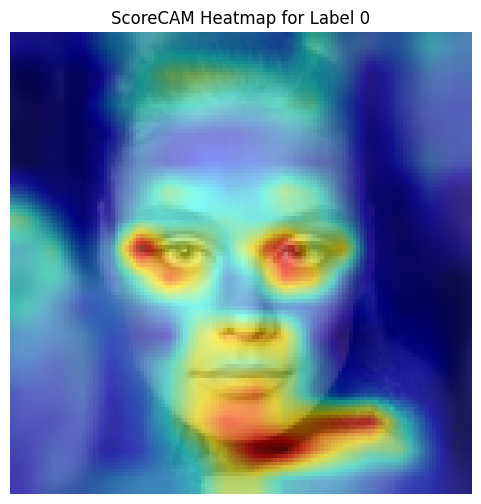

100%|██████████| 8/8 [00:00<00:00, 222.56it/s]


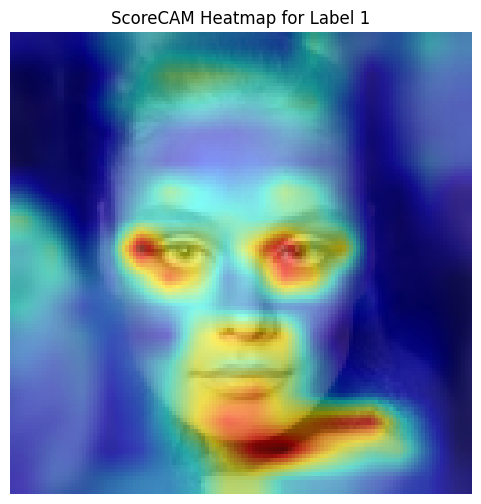

100%|██████████| 8/8 [00:00<00:00, 216.47it/s]


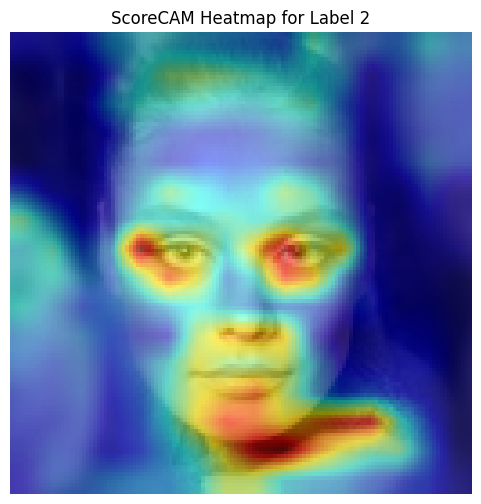

100%|██████████| 8/8 [00:00<00:00, 221.31it/s]


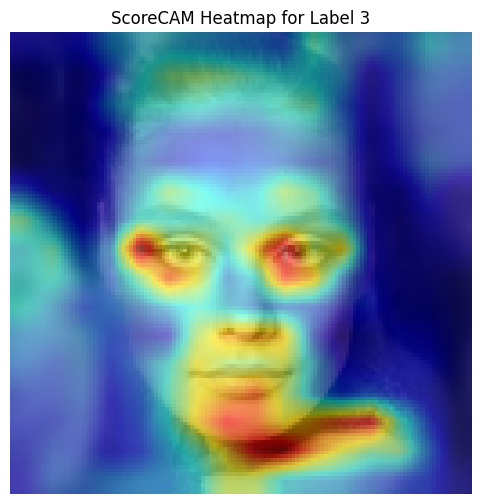

100%|██████████| 8/8 [00:00<00:00, 196.54it/s]


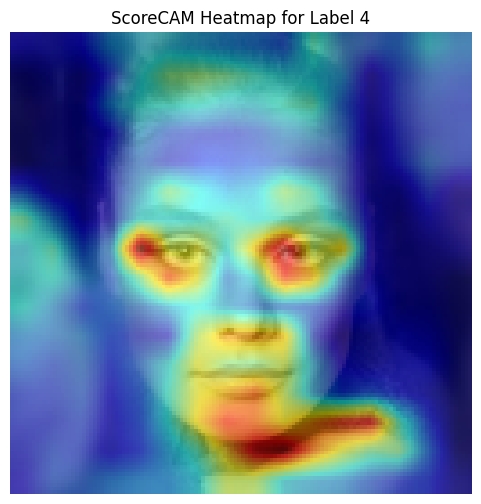

100%|██████████| 8/8 [00:00<00:00, 220.44it/s]


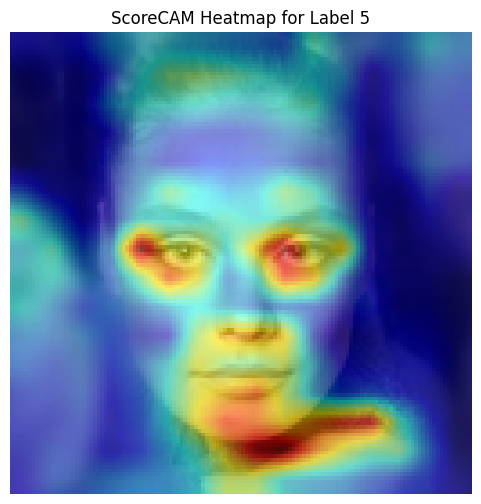

100%|██████████| 8/8 [00:00<00:00, 194.95it/s]


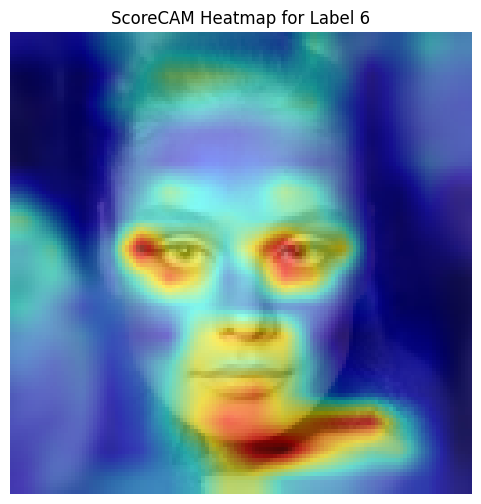

100%|██████████| 8/8 [00:00<00:00, 221.76it/s]


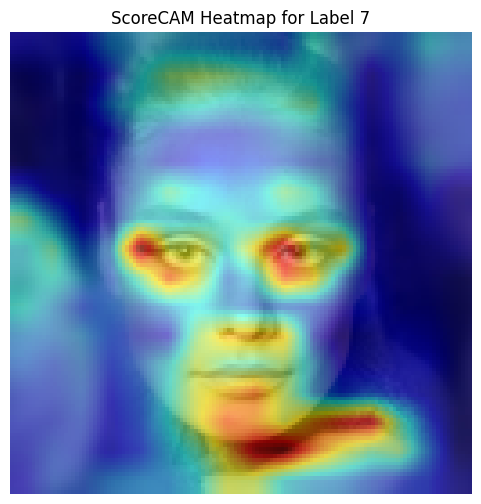

100%|██████████| 8/8 [00:00<00:00, 219.74it/s]


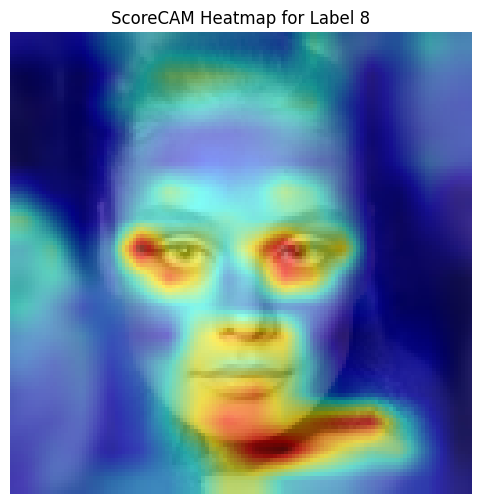

100%|██████████| 8/8 [00:00<00:00, 220.55it/s]


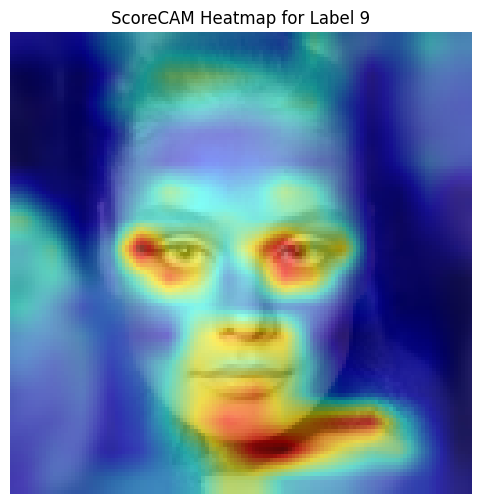

100%|██████████| 8/8 [00:00<00:00, 219.61it/s]


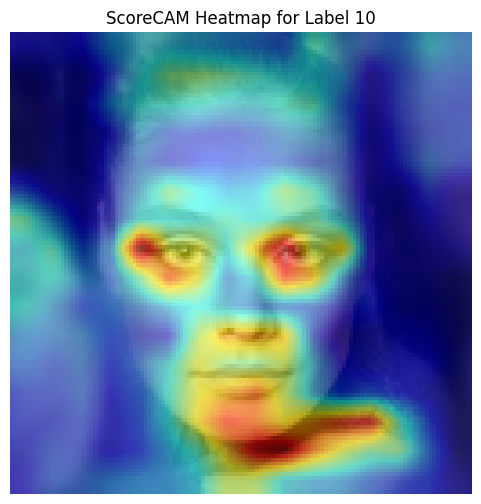

100%|██████████| 8/8 [00:00<00:00, 219.92it/s]


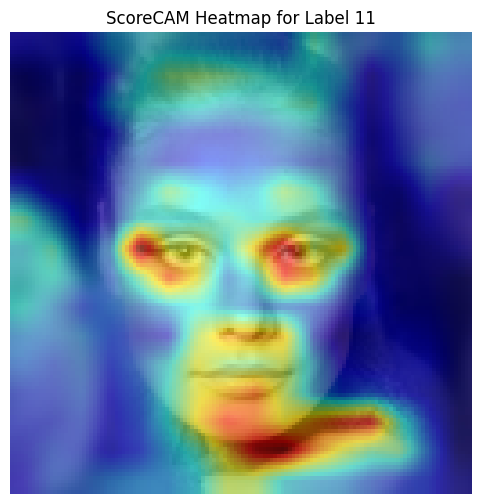

100%|██████████| 8/8 [00:00<00:00, 221.55it/s]


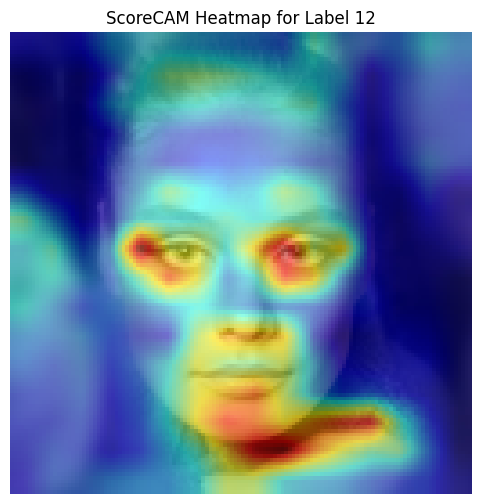

100%|██████████| 8/8 [00:00<00:00, 221.66it/s]


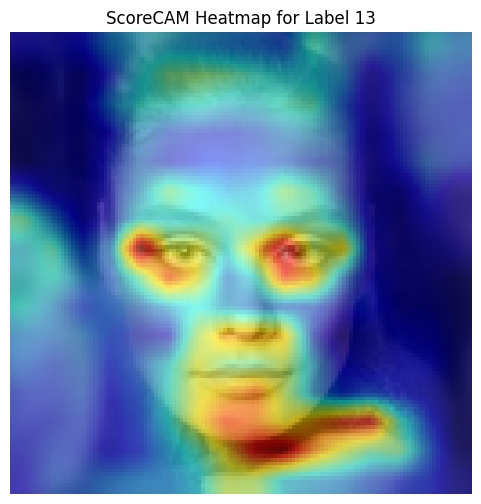

100%|██████████| 8/8 [00:00<00:00, 221.42it/s]


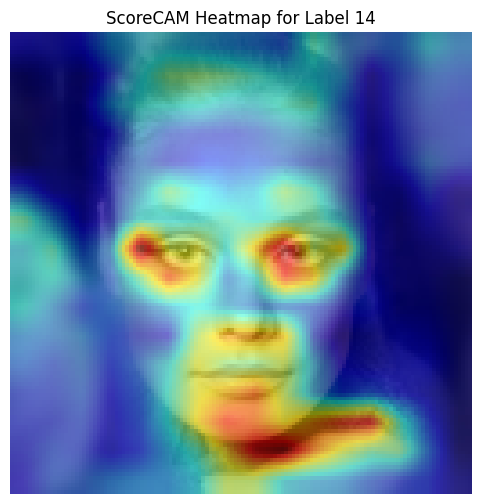

100%|██████████| 8/8 [00:00<00:00, 221.64it/s]


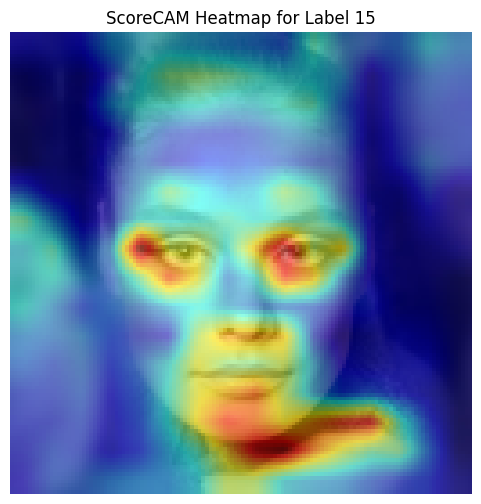

100%|██████████| 8/8 [00:00<00:00, 219.93it/s]


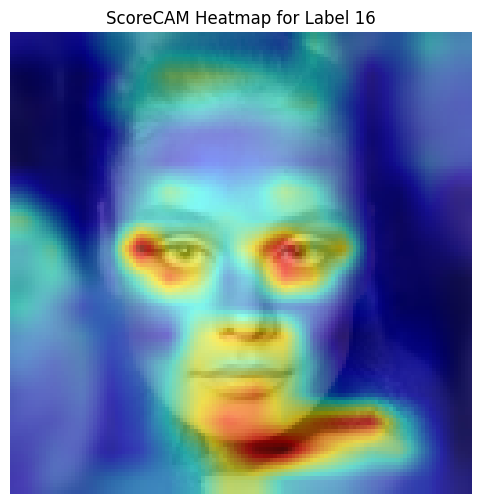

100%|██████████| 8/8 [00:00<00:00, 220.20it/s]


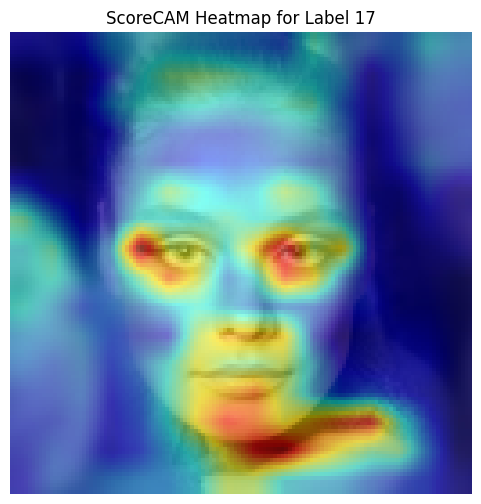

100%|██████████| 8/8 [00:00<00:00, 209.47it/s]


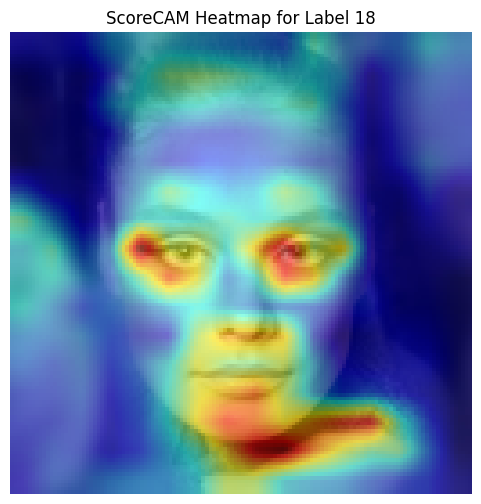

100%|██████████| 8/8 [00:00<00:00, 220.36it/s]


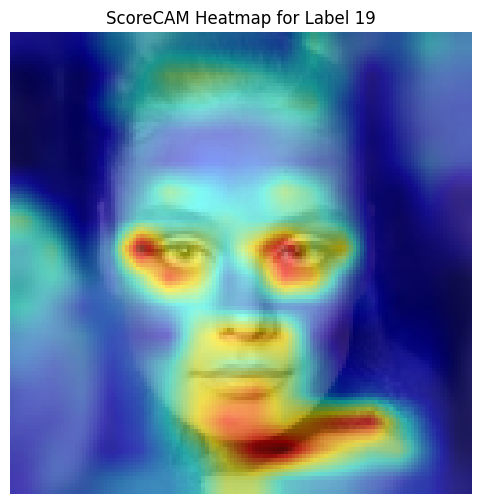

100%|██████████| 8/8 [00:00<00:00, 220.42it/s]


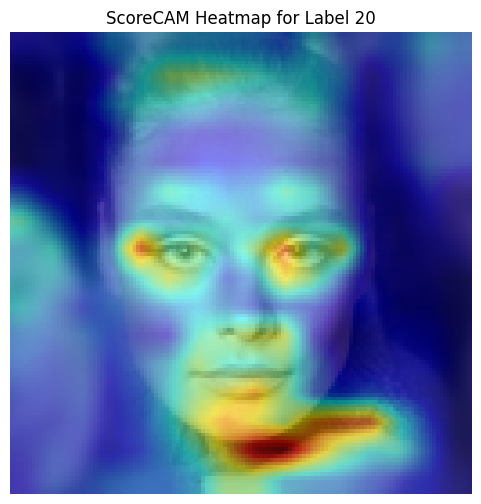

100%|██████████| 8/8 [00:00<00:00, 221.03it/s]


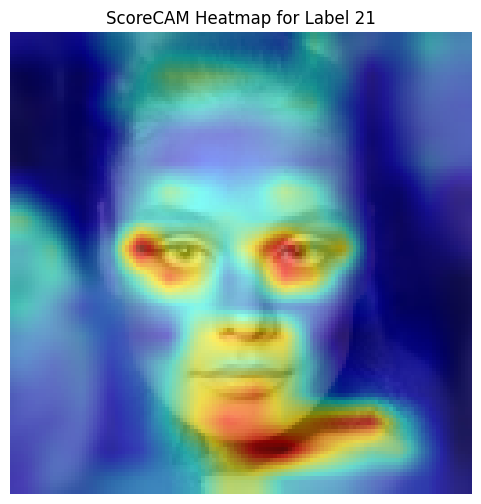

100%|██████████| 8/8 [00:00<00:00, 219.53it/s]


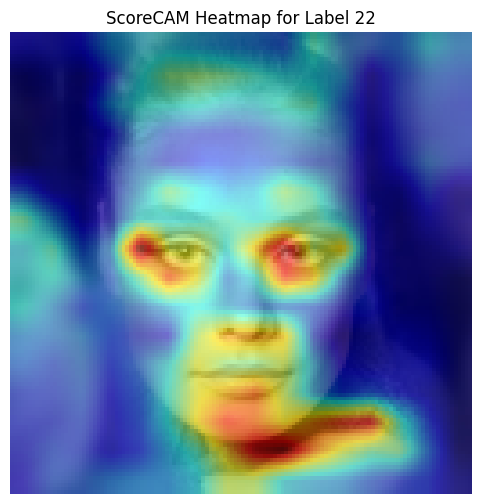

100%|██████████| 8/8 [00:00<00:00, 216.58it/s]


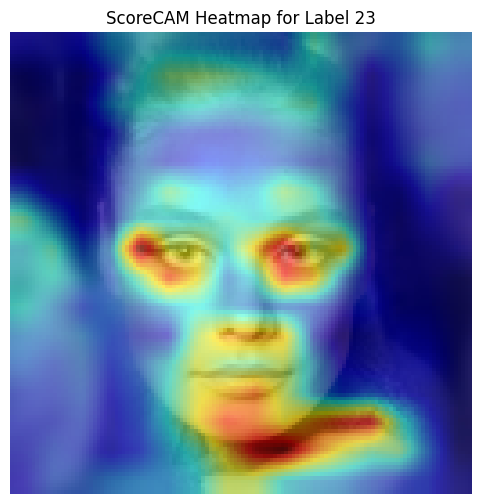

100%|██████████| 8/8 [00:00<00:00, 212.91it/s]


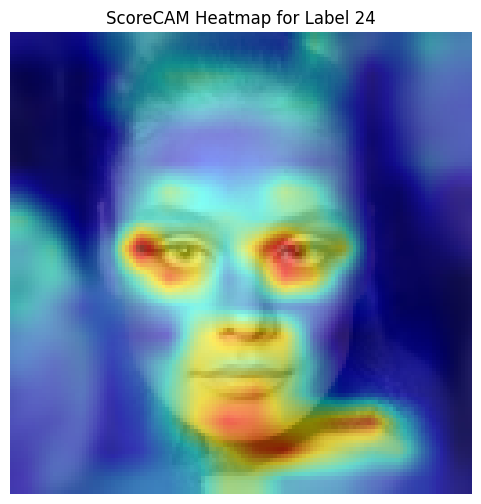

100%|██████████| 8/8 [00:00<00:00, 214.19it/s]


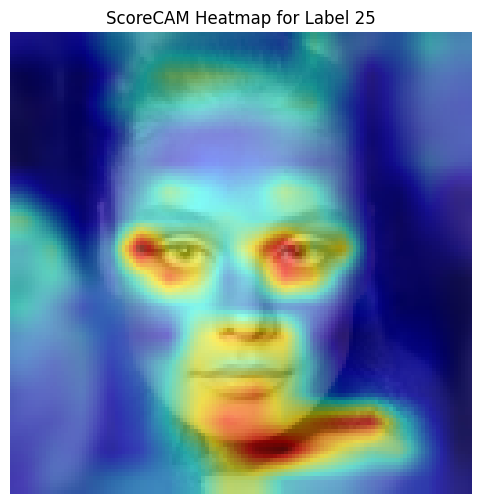

100%|██████████| 8/8 [00:00<00:00, 217.97it/s]


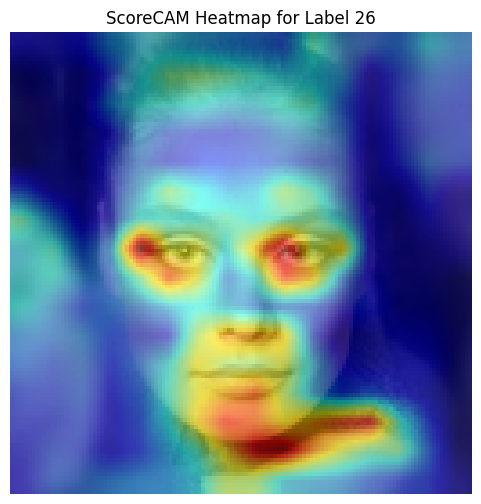

100%|██████████| 8/8 [00:00<00:00, 216.99it/s]


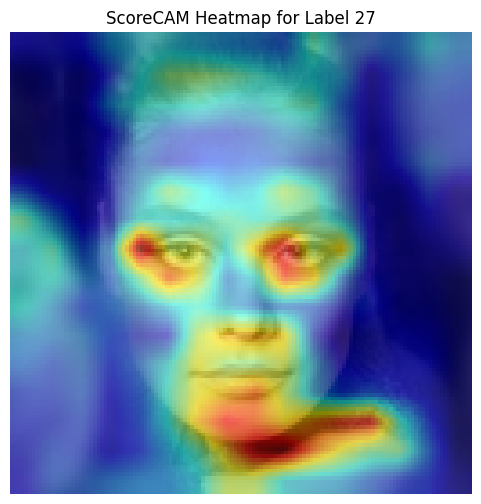

100%|██████████| 8/8 [00:00<00:00, 216.69it/s]


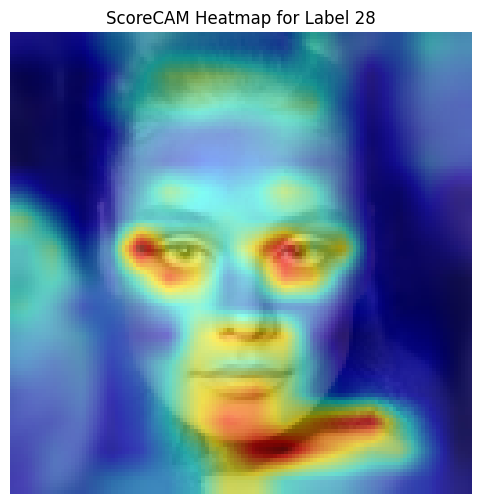

100%|██████████| 8/8 [00:00<00:00, 215.70it/s]


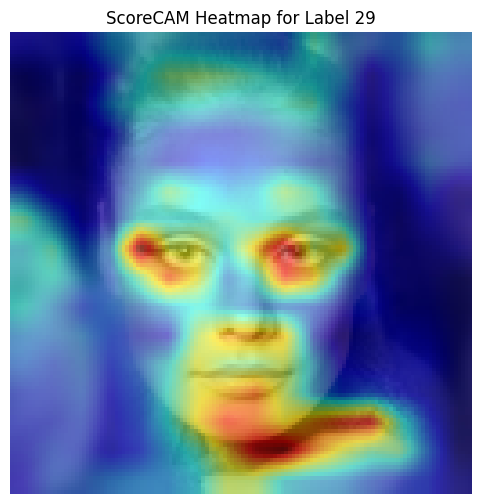

100%|██████████| 8/8 [00:00<00:00, 216.05it/s]


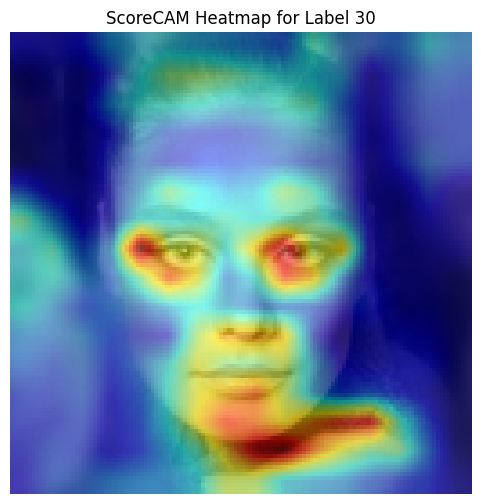

100%|██████████| 8/8 [00:00<00:00, 219.19it/s]


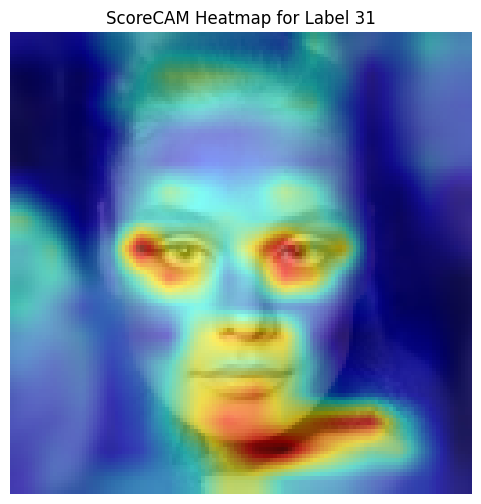

100%|██████████| 8/8 [00:00<00:00, 214.91it/s]


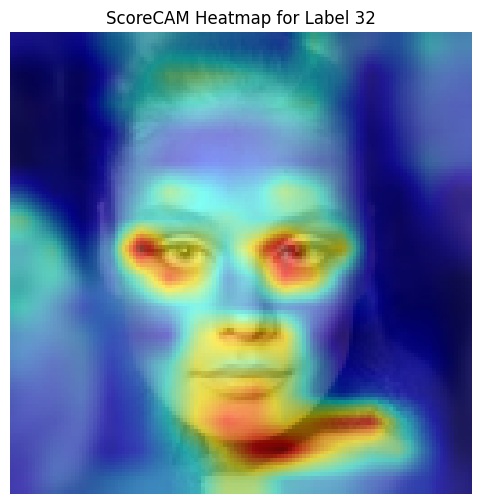

100%|██████████| 8/8 [00:00<00:00, 214.98it/s]


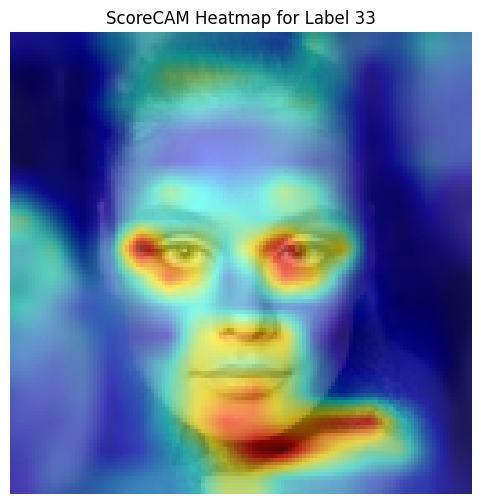

100%|██████████| 8/8 [00:00<00:00, 216.13it/s]


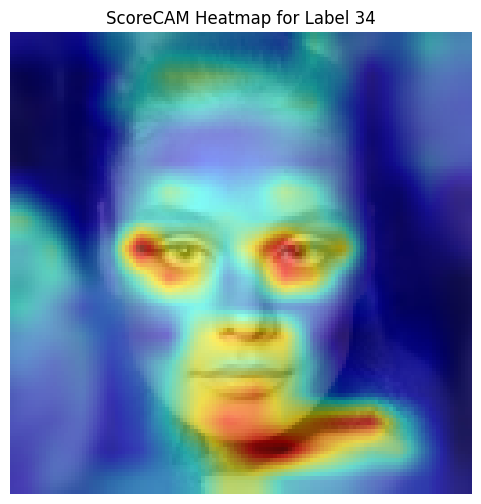

100%|██████████| 8/8 [00:00<00:00, 220.77it/s]


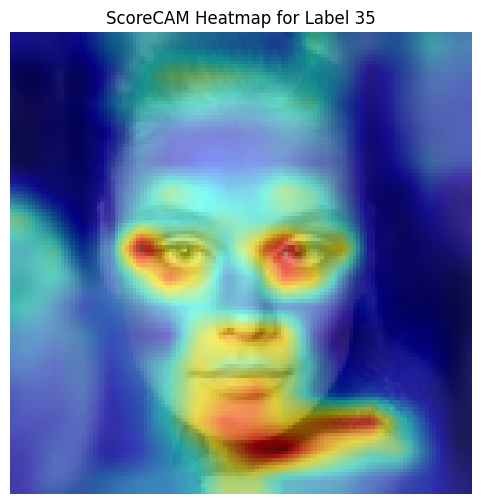

100%|██████████| 8/8 [00:00<00:00, 219.34it/s]


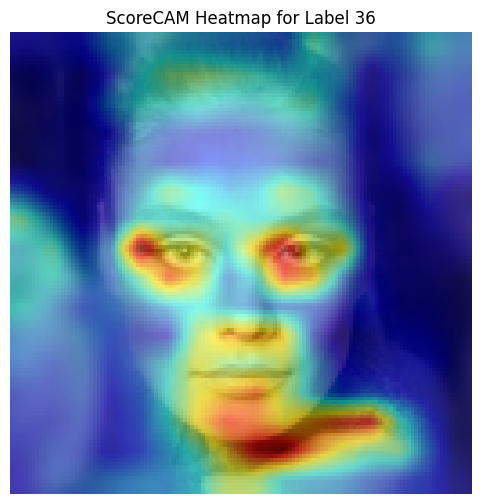

100%|██████████| 8/8 [00:00<00:00, 219.86it/s]


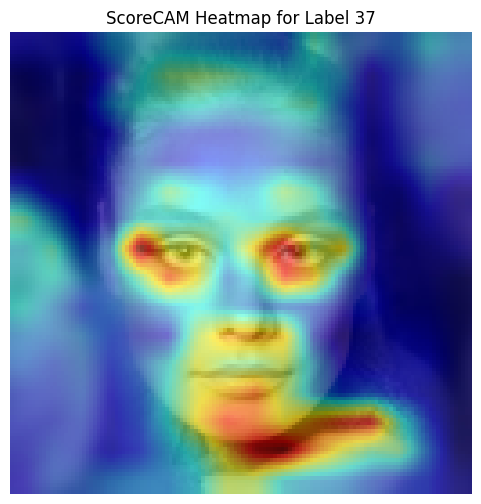

100%|██████████| 8/8 [00:00<00:00, 199.67it/s]


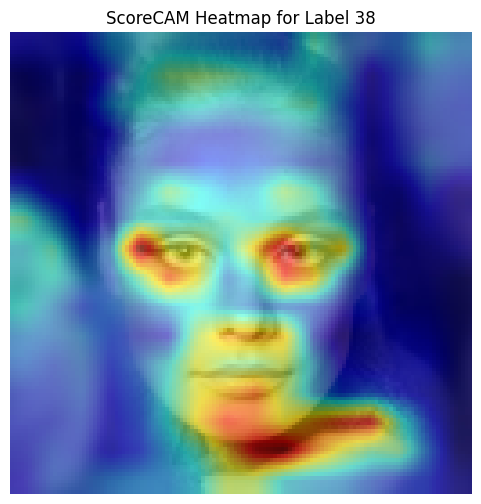

100%|██████████| 8/8 [00:00<00:00, 220.79it/s]


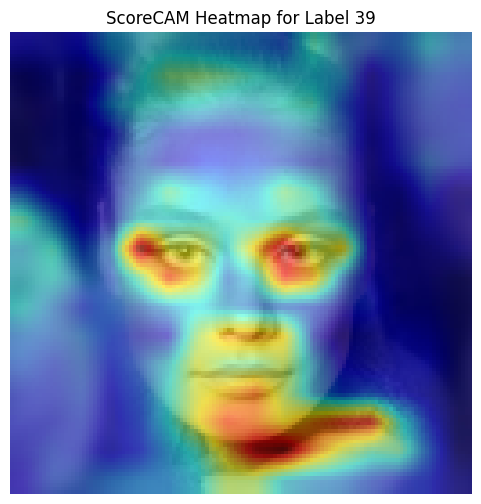

In [50]:
example_image_path = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img/110.jpg'  # Update with the path to an example imag

for label_index in range(40):
    generate_heatmap_for_label(example_image_path, cnn_loaded_model, target_layer=cnn_loaded_model.conv[-1], label_index=label_index)